First, lets import all necessary modules, including Matplotlib for plotting

Also, define parameters for plotting, including colors

In [1]:
import os
import sys
import math
import copy

if sys.platform=="cygwin":
    from cyglibra_core import *
elif sys.platform=="linux" or sys.platform=="linux2":
    from liblibra_core import *

from libra_py import units
import libra_py.workflows.nbra.step4 as step4


import matplotlib.pyplot as plt   # plots
%matplotlib inline 

plt.rc('axes', titlesize=24)      # fontsize of the axes title
plt.rc('axes', labelsize=20)      # fontsize of the x and y labels
plt.rc('legend', fontsize=20)     # legend fontsize
plt.rc('xtick', labelsize=16)    # fontsize of the tick labels
plt.rc('ytick', labelsize=16)    # fontsize of the tick labels

plt.rc('figure.subplot', left=0.2)
plt.rc('figure.subplot', right=0.95)
plt.rc('figure.subplot', bottom=0.13)
plt.rc('figure.subplot', top=0.88)

colors = {}

colors.update({"11": "#8b1a0e"})  # red       
colors.update({"12": "#FF4500"})  # orangered 
colors.update({"13": "#B22222"})  # firebrick 
colors.update({"14": "#DC143C"})  # crimson   

colors.update({"21": "#5e9c36"})  # green
colors.update({"22": "#006400"})  # darkgreen  
colors.update({"23": "#228B22"})  # forestgreen
colors.update({"24": "#808000"})  # olive      

colors.update({"31": "#8A2BE2"})  # blueviolet
colors.update({"32": "#00008B"})  # darkblue  

colors.update({"41": "#2F4F4F"})  # darkslategray

/home/alexey/miniconda2/envs/py37/lib/python3.7/importlib/_bootstrap.py:219: RuntimeWarning: to-Python converter for std::vector<std::complex<double>, std::allocator<std::complex<double> > > already registered; second conversion method ignored.
  return f(*args, **kwds)
/home/alexey/miniconda2/envs/py37/lib/python3.7/importlib/_bootstrap.py:219: RuntimeWarning: to-Python converter for std::vector<std::vector<int, std::allocator<int> >, std::allocator<std::vector<int, std::allocator<int> > > > already registered; second conversion method ignored.
  return f(*args, **kwds)
/home/alexey/miniconda2/envs/py37/lib/python3.7/importlib/_bootstrap.py:219: RuntimeWarning: to-Python converter for boost::python::detail::container_element<std::vector<std::vector<int, std::allocator<int> >, std::allocator<std::vector<int, std::allocator<int> > > >, unsigned long, boost::python::detail::final_vector_derived_policies<std::vector<std::vector<int, std::allocator<int> >, std::allocator<std::vector<int, s

Here is where we define our model. For this model, we can denerate the Hvib matrices along the pre-computed trajectories (the NBRA assumption). NBRA = neglect of back-reaction approximation. 

In this example, we only imagine a system evolving in time such that the adiabatic energies and non-adiabatic couplings are constant for all times - really the simplest model problem. Well, in reality, this may be not that simple to realise, but we don't care here.

We generate a single data set (one "trajectory") - that's why len(Hvib) == 1 

The trajectory comprises nsteps = 1000 nuclear timesteps

Adiabatic energy levels are at -0.001 and 0.001 a.u. and the NAC is at 0.001 a.u. as well

In [2]:
nsteps = 100

# Populate Hvib - this is our model
Hvib = []
hvib = []
for i in range(nsteps):
    hvib.append(CMATRIX(2,2))
    hvib[i].set(0,0,-0.000+0.0j);   hvib[i].set(0,1, 0.0+0.005j);
    hvib[i].set(1,0, 0.0-0.005j);   hvib[i].set(1,1, 0.02+0.0j);
Hvib.append(hvib)

We can also to an arbitrary scaling of the Hamiltonian.

Uncomment the line in the code below to increase the gap by 0.1 and multiply the coupling by a factor of 3

In [3]:
scl = CMATRIX(2,2)
scl.set(0,0, 1.0+0.0j);  scl.set(0,1, 3.0+0.0j);
scl.set(0,0, 3.0+0.0j);  scl.set(0,1, 1.0+0.0j);

shi = CMATRIX(2,2)
shi.set(0,0, 0.0+0.0j);  shi.set(0,1, 0.0+0.0j);
shi.set(0,0, 0.0+0.0j);  shi.set(0,1, 0.1+0.0j);

#step4.transform_data(Hvib, {"shift2":shi, "scale":scl })

Now, lets set up all the simulation parameters, such as the number of TSH trajectories (stochastic realizations, temperature, TSH algorithm, decoherence, etc.)

Note, that we start all trajectories in state 1 (upper energy state) - see the "istate" variable. 

In this example, we don't need to average over initial nuclear configurations (which is a sampling over initial times). This is done by setting "init_times" to a list with only one entry \[0\] 

Our simulation includes 2 states, so set "nstates" variable to 2

Also, which might be a bit confusing - we need to set up the "data_set_paths" variable such that it contains as many data elements (1 in our example) as the data samples we have. The name implies that one would have these files stored in the corresponding paths, but in this example we avoid I/O, so we don't actually generate any intermediate Hvib files. So, we don't actually have much to define as the "data_set_paths" variable. But to obey the number of terms, we simply insert the dummy (empty string) variable. 

In [4]:
params = {}
params.update({"T":300.0, "ntraj":1000, "sh_method":1, "decoherence_method":2, "dt":41.0})
params.update({"nsteps":nsteps, "Boltz_opt":1})
params.update({"istate":1, "init_times":[0], "outfile":"_out.txt"})
params.update({"data_set_paths":[""]})
params["decoherence_constants"] = 1

tau = MATRIX(2,2)
t01 = 10.0 * units.fs2au
tau.set(0, 1, t01);
tau.set(1, 0, t01);  
params["decoherence_times"] = tau



Now, lets run the TSH calculations.

The output is a nsteps x 10 matrix, wich contains all sorts of information - energies, populations, different types of weighted sums. The example format for a 2-state calculation is shown below.

In [5]:
# nstates = 2 => n_cols = 2*3 + 4 = 11
#        0    1      2     3    4      5      6     7     8    9    10
# res =  t   E0, P_SE0, P_SH0, E1, P_SE1, P_SH1, E_SE, E_SH, P_SE, P_SH
res = step4.run(Hvib, params)

The nsteps x 10 matrix returned above needs to be uppacked so that the resulting Python lists could be used in plotting with matplotlib.

In [6]:
t = []
shE, shP0, shP1 = [], [], []
seE, seP0, seP1 = [], [], []
for i in range(nsteps):
    t.append(res.get(i, 0)*units.au2fs )  # time
    shE.append(res.get(i, 8))   # SH-weighted energy
    shP0.append(res.get(i, 3))  # SH pop of state 0
    shP1.append(res.get(i, 6))  # SH pop of state 1
    
    seE.append(res.get(i, 7))   # SE-weighted energy
    seP0.append(res.get(i, 2))  # SE pop of state 0
    seP1.append(res.get(i, 5))  # SE pop of state 1

Finally, we can plot the results. 

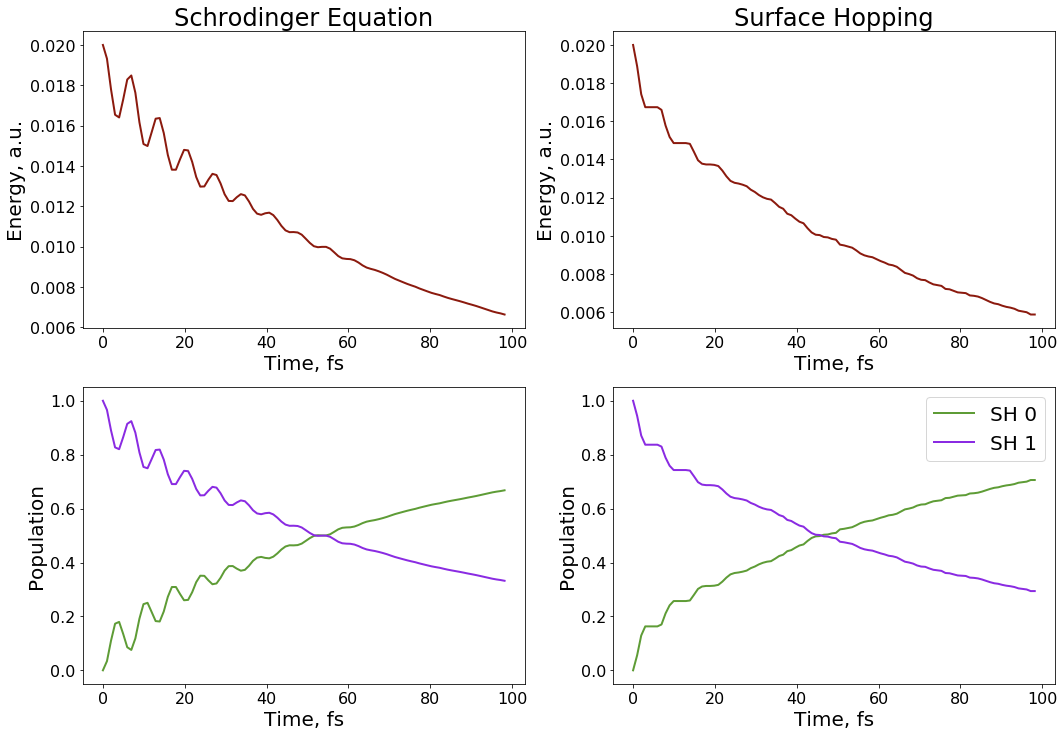

In [7]:
plt.figure(1, figsize=(18, 12)) # dpi=300, frameon=False)
plt.subplot(2,2,1)
plt.title('Schrodinger Equation')
plt.xlabel('Time, fs')
plt.ylabel('Energy, a.u.')
plt.plot(t, seE, label='', linewidth=2, color = colors["11"]) 

plt.subplot(2,2,2)
plt.title('Surface Hopping')
plt.xlabel('Time, fs')
plt.ylabel('Energy, a.u.')
plt.plot(t, shE, label='', linewidth=2, color = colors["11"]) 


plt.subplot(2,2,3)
plt.xlabel('Time, fs')
plt.ylabel('Population')
plt.plot(t, seP0, label='SE 0', linewidth=2, color = colors["21"]) 
plt.plot(t, seP1, label='SE 1', linewidth=2, color = colors["31"]) 

plt.subplot(2,2,4)
plt.xlabel('Time, fs')
plt.ylabel('Population')
plt.plot(t, shP0, label='SH 0', linewidth=2, color = colors["21"]) 
plt.plot(t, shP1, label='SH 1', linewidth=2, color = colors["31"]) 

plt.legend()
plt.show()
plt.close()

We can now also look at the relative population of the two states when the system reaches termal equilibrium. Do the computed populations agree with what is expected from the Boltzmann distribution?

In [9]:
E0 = Hvib[0][0].get(0,0).real
E1 = Hvib[0][0].get(1,1).real
boltz_ratio = math.exp(-(E1-E0)/(units.kB*params["T"]))
print("Expected Boltzman populations factor, total pop on state 1 / total pot on stat 0 ", boltz_ratio)
print( "actual ration of the SH populations on the two states, at equilibrium = ", shP1[99]/shP0[99])
print( "actual ration of the SE populations on the two states, at equilibrium = ", seP1[99]/seP0[99])

Expected Boltzman populations factor, total pop on state 1 / total pot on stat 0  7.200903180154815e-10
actual ration of the SH populations on the two states, at equilibrium =  0.4164305949008498
actual ration of the SE populations on the two states, at equilibrium =  0.49736178521160174
